C:\Users\user\AppData\Local\Temp\ipykernel_23380\3774355359.py:98: DtypeWarning: Columns (108,112,113,117,151,154,161,162,164,169,180,185,198,221,228,264,267,269,270,306,307,310,311,314,315,318,319,322,323,326,328,330,331,334,335,338,339,342,343,346,348,350,352,354,356,358,362,363,393,403,404,406,418,423,430,433,436,439,444) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv(data_path)


Epoch 1, Train Loss: 0.6099, Train Acc: 0.6532, Test Loss: 0.5895, Test Acc: 0.6628
Epoch 2, Train Loss: 0.5783, Train Acc: 0.6756, Test Loss: 0.5427, Test Acc: 0.7109
Epoch 3, Train Loss: 0.5635, Train Acc: 0.6899, Test Loss: 0.5284, Test Acc: 0.7093
Epoch 4, Train Loss: 0.5516, Train Acc: 0.6990, Test Loss: 0.5138, Test Acc: 0.7317
Epoch 5, Train Loss: 0.5429, Train Acc: 0.7039, Test Loss: 0.5154, Test Acc: 0.7303
Epoch 6, Train Loss: 0.5380, Train Acc: 0.7096, Test Loss: 0.4966, Test Acc: 0.7404
Epoch 7, Train Loss: 0.5336, Train Acc: 0.7123, Test Loss: 0.4915, Test Acc: 0.7378
Epoch 8, Train Loss: 0.5314, Train Acc: 0.7129, Test Loss: 0.4885, Test Acc: 0.7352
Epoch 9, Train Loss: 0.5248, Train Acc: 0.7159, Test Loss: 0.4831, Test Acc: 0.7439
Epoch 10, Train Loss: 0.5229, Train Acc: 0.7182, Test Loss: 0.4731, Test Acc: 0.7538
Epoch 11, Train Loss: 0.5190, Train Acc: 0.7194, Test Loss: 0.4832, Test Acc: 0.7369
Epoch 12, Train Loss: 0.5199, Train Acc: 0.7202, Test Loss: 0.4732, Test A

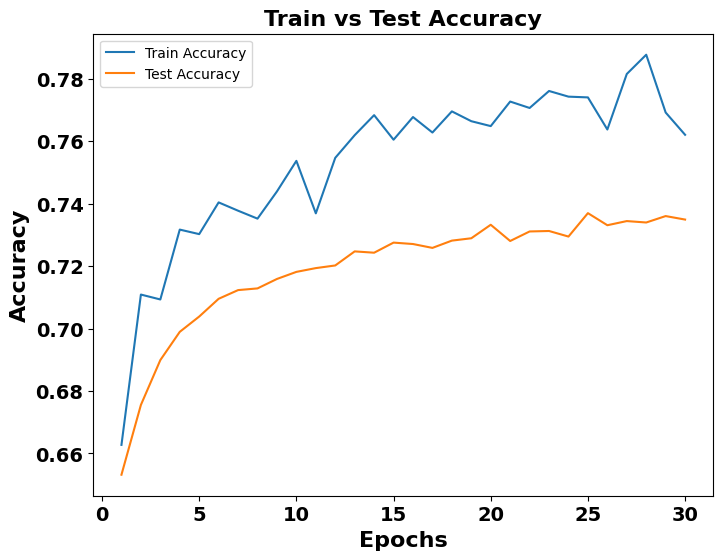

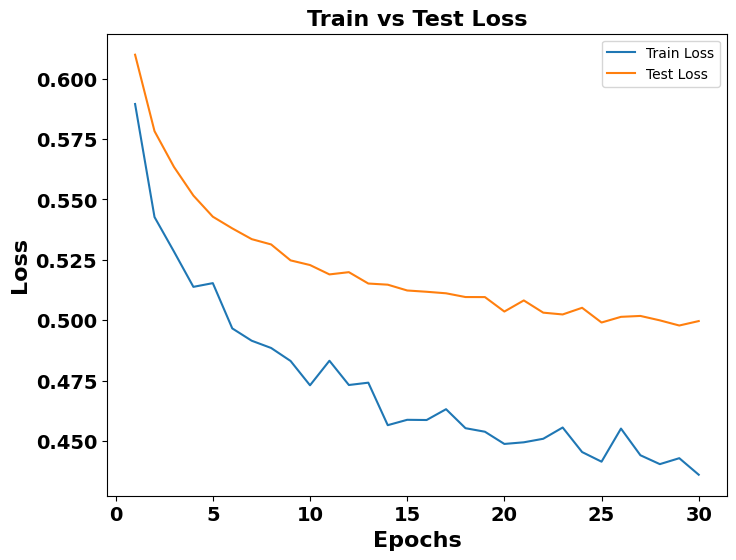

Model saved to _QOR_Stgcn_model_20250603_152110.pth


NameError: name 'accuracy' is not defined

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pickle
from datetime import datetime


# Define joints and edges
joints = [
    'PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
    'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
    'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
    'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
    'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
    'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT'
]

edges = [
    ('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
    ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
    ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
    ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
    ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
    ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
    ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
    ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
    ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
    ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'), ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')
]

joint_to_idx = {joint: idx for idx, joint in enumerate(joints)}
edge_index = torch.tensor(
    [[joint_to_idx[src], joint_to_idx[dst]] for src, dst in edges] +
    [[joint_to_idx[dst], joint_to_idx[src]] for src, dst in edges],  # Bidirectional edges
    dtype=torch.long
).t()

# Dataset class (WITHOUT timestamps)
class SkeletonDataset(Dataset):
    def __init__(self, csv_file):
        self.data = csv_file
        self.num_nodes = len(joints)
        self.scaler = StandardScaler()
        
        # Normalize joint features
        joint_columns = [f'{joint}_{axis}' for joint in joints for axis in ['X', 'Y', 'Z']]
        self.data[joint_columns] = self.scaler.fit_transform(self.data[joint_columns])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Extract node features (ONLY X, Y, Z)
        node_features = [[row[f'{joint}_X'], row[f'{joint}_Y'], row[f'{joint}_Z']] for joint in joints]
        x = torch.tensor(node_features, dtype=torch.float)  # Shape: [num_nodes, 3]
        y = torch.tensor([row['QoR_class']], dtype=torch.float)  # Ensure y has shape [1]
        return Data(x=x, edge_index=edge_index, y=y)

# Define ST-GCN model (With Fixes)
class STGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(STGCN, self).__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)  # ✅ Batch Normalization
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.gcn3 = GCNConv(hidden_channels, hidden_channels)  # ✅ Added Extra GCN Layer
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = data.batch if hasattr(data, 'batch') else None  # Handle batch processing

        x = F.leaky_relu(self.bn1(self.gcn1(x, edge_index)))  # ✅ LeakyReLU instead of ReLU
        x = F.leaky_relu(self.bn2(self.gcn2(x, edge_index)))
        x = F.leaky_relu(self.gcn3(x, edge_index))  # ✅ Third GCN Layer

        # Global Mean Pooling
        if batch is not None:
            x = global_mean_pool(x, batch)
        else:
            x = x.mean(dim=0, keepdim=True)  # Ensure batch shape

        x = self.fc(x)
        return x.squeeze()  # No Sigmoid here (Handled in BCEWithLogitsLoss)

# Load dataset
data_path =  r"D:\Data\NYC\KINZ\KINECT_ACC_dataset_with_qor15_2025-05-27_14-29PM.csv"
dataframe = pd.read_csv(data_path)
dataframe = dataframe[dataframe['walking_speed'] == "Fast"]
dataframe = dataframe[dataframe['QoR_class'].isin([0, 1])].copy()
dataset = SkeletonDataset(csv_file=dataframe)

# Split into train/test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 32  # ✅ Increased batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = STGCN(in_channels=3, hidden_channels=256, num_classes=1).to(device)  # ✅ Increased hidden size
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  # ✅ Increased LR

# Initialize Lists for Losses and Accuracies
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# Training Loop
num_epochs = 30
for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        y = data.y.to(device).float()

        loss = criterion(out.view(-1), y.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs
        correct += ((out >= 0).float() == y).sum().item()
        total += data.num_graphs

    avg_train_loss, train_accuracy = total_loss / len(train_loader.dataset), correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation on Test Data
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            y = data.y.to(device).float()

            loss = criterion(out.view(-1), y.view(-1))
            total_loss += loss.item() * data.num_graphs
            correct += ((out >= 0).float() == y).sum().item()
            total += data.num_graphs

    avg_test_loss, test_accuracy = total_loss / len(test_loader.dataset), correct / total
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

# Plot Training and Testing Accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, test_accuracies, label='Train Accuracy')
plt.plot(epochs, train_accuracies, label='Test Accuracy')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.title('Train vs Test Accuracy', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

# Plot Training and Testing Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, test_losses, label='Train Loss')
plt.plot(epochs, train_losses, label='Test Loss')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.title('Train vs Test Loss', fontsize=16, fontweight='bold')
plt.legend()
plt.show()


# Get the current timestamp
current_time = datetime.now().strftime('%Y%m%d_%H%M%S')  # Format: YYYYMMDD_HHMMSS

# Save the trained model to the specified directory with timestamp
model_save_path = f'_QOR_Stgcn_model_{current_time}.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Save training and evaluation statistics
model_stats = {
    'train_losses': train_losses,
    'test_losses': test_losses,
    'train_accuracies': train_accuracies,
    'test_accuracies': test_accuracies,
    'final_metrics': {
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'precision': precision,
        'specificity': specificity,
        'roc_auc': roc_auc
    }
}

# Save training and evaluation statistics to the specified directory with timestamp
stats_save_path = f'QOR_Stgcn_model_statistics_{current_time}.pkl'
with open(stats_save_path, 'wb') as f:
    pickle.dump(model_stats, f)




In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle


# Load dataset
data_path =  r"D:\Data\NYC\KINZ\KINECT_ACC_dataset_with_qor15_2025-05-27_14-29PM.csv"
dataframe = pd.read_csv(data_path)
dataframe = dataframe[dataframe['walking_speed'] == "Fast"]
dataframe = dataframe[dataframe['QoR_class'].isin([0, 1])].copy()
dataset = SkeletonDataset(csv_file=dataframe)




# 2. Graph Definition
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
         ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
         ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
         ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
         ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
         ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
         ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
         ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
         ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
         ('HEAD', 'NOSE'), ('HEAD','EYE_LEFT'), ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')]

joint_to_idx = {joint: idx for idx, joint in enumerate(joints)}
edge_index = torch.tensor([[joint_to_idx[src], joint_to_idx[dst]] for src, dst in edges] +
                          [[joint_to_idx[dst], joint_to_idx[src]] for src, dst in edges],
                          dtype=torch.long).t()

# 3. Dataset
class SkeletonDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.data = df
        self.num_nodes = len(joints)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        node_features = [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['t_uniform']] for j in joints]
        x = torch.tensor(node_features, dtype=torch.float)
        y = torch.tensor(row['QoR_class'], dtype=torch.float)
        return Data(x=x, edge_index=edge_index, y=y)

# 4. Random split
full_dataset = SkeletonDataset(dataframe.dropna(subset=['QoR_class']))
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# 5. Weighted Sampling
train_indices = train_dataset.indices if isinstance(train_dataset, torch.utils.data.Subset) else list(range(len(train_dataset)))
train_df = dataframe.iloc[train_indices].reset_index(drop=True)
train_df = train_df.dropna(subset=['QoR_class'])
class_counts = train_df['QoR_class'].value_counts().sort_index().to_numpy()
class_weights = 1. / class_counts
sample_weights = [class_weights[int(label)] for label in train_df['QoR_class']]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# 6. Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# 7. Model
class HybridSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.temporal_conv1 = nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = getattr(data, 'batch', None)
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))
        batch_size = batch.max().item() + 1 if batch is not None else 1
        num_nodes = x.size(0) // batch_size
        x = x.view(batch_size, num_nodes, -1).permute(0, 2, 1)
        x = F.relu(self.temporal_conv1(x)).permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x.mean(dim=1)
        return self.fc(x).squeeze()

# 8. Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridSTGCN(in_channels=4, hidden_channels=128, num_classes=1).to(device)
pos_weight = torch.tensor([class_weights[0] / class_weights[1]]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.005):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.best_model is not None:
                    model.load_state_dict(self.best_model)
                return True
        return False

# 9. Training Loop
num_epochs = 100
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
early_stopping = EarlyStopping()

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        y = data.y.to(device).float()
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        correct += ((out >= 0.5) == y).sum().item()
        total += data.num_graphs
    train_loss = total_loss / len(train_loader.dataset)
    train_acc = correct / total

    model.eval()
    total_loss, correct, total, all_preds, all_labels = 0, 0, 0, [], []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            y = data.y.to(device).float()
            loss = criterion(out, y)
            total_loss += loss.item() * data.num_graphs
            pred = (torch.sigmoid(out) >= 0.5).float()
            correct += (pred == y).sum().item()
            total += data.num_graphs
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss = total_loss / len(test_loader.dataset)
    test_acc = correct / total
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

    if early_stopping(test_loss, model):
        print("Early stopping triggered.")
        break

# 10. Final Evaluation
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_preds)
tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
specificity = tn / (tn + fp)

print(f"Final Test Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=['Good (0)', 'Not Good (1)']))

# 11. Save Model + Stats
now = datetime.now().strftime("%Y%m%d_%H%M%S")
torch.save(model.state_dict(), f"QOR_hybrid_stgcn_model_{now}.pth")
with open(f"QOR_hybrid_stgcn_model_statistics_{now}.pkl", 'wb') as f:
    pickle.dump({
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'final_metrics': {
            'accuracy': accuracy,
            'f1_score': f1,
            'recall': recall,
            'precision': precision,
            'specificity': specificity,
            'roc_auc': roc_auc
        }
    }, f)
print("Model and statistics saved.")


C:\Users\user\AppData\Local\Temp\ipykernel_23380\1973237351.py:19: DtypeWarning: Columns (108,112,113,117,151,154,161,162,164,169,180,185,198,221,228,264,267,269,270,306,307,310,311,314,315,318,319,322,323,326,328,330,331,334,335,338,339,342,343,346,348,350,352,354,356,358,362,363,393,403,404,406,418,423,430,433,436,439,444) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv(data_path)


Epoch 001 | Train Loss: 0.5632, Acc: 0.5320 | Test Loss: 0.5212, Acc: 0.6435
Epoch 002 | Train Loss: 0.5223, Acc: 0.5931 | Test Loss: 0.4936, Acc: 0.6790
Epoch 003 | Train Loss: 0.4947, Acc: 0.6237 | Test Loss: 0.4659, Acc: 0.7012
Epoch 004 | Train Loss: 0.4743, Acc: 0.6350 | Test Loss: 0.4556, Acc: 0.7181
Epoch 005 | Train Loss: 0.4560, Acc: 0.6514 | Test Loss: 0.4308, Acc: 0.7020
Epoch 006 | Train Loss: 0.4382, Acc: 0.6678 | Test Loss: 0.4144, Acc: 0.7298
Epoch 007 | Train Loss: 0.4211, Acc: 0.6738 | Test Loss: 0.4001, Acc: 0.7333
Epoch 008 | Train Loss: 0.4077, Acc: 0.6808 | Test Loss: 0.3929, Acc: 0.7321
Epoch 009 | Train Loss: 0.3938, Acc: 0.6898 | Test Loss: 0.3652, Acc: 0.7563
Epoch 010 | Train Loss: 0.3833, Acc: 0.6910 | Test Loss: 0.4144, Acc: 0.7286
Epoch 011 | Train Loss: 0.3729, Acc: 0.6933 | Test Loss: 0.3451, Acc: 0.7631
Epoch 012 | Train Loss: 0.3614, Acc: 0.7015 | Test Loss: 0.3515, Acc: 0.7766
Epoch 013 | Train Loss: 0.3495, Acc: 0.7105 | Test Loss: 0.3296, Acc: 0.7887